Installing packages required to work with Azure ML studio

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
travel_churn_data = pd.read_csv('data/CustomerTravel.csv')

travel_churn_data.head()

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target
0,34,No,Middle Income,6,No,Yes,0
1,34,Yes,Low Income,5,Yes,No,1
2,37,No,Middle Income,3,Yes,No,0
3,30,No,Middle Income,2,No,No,0
4,30,No,Low Income,1,No,No,0


In [3]:
travel_churn_data.columns

Index(['Age', 'FrequentFlyer', 'AnnualIncomeClass', 'ServicesOpted',
       'AccountSyncedToSocialMedia', 'BookedHotelOrNot', 'Target'],
      dtype='object')

In [4]:
travel_churn_data['AnnualIncomeClass'].unique()

array(['Middle Income', 'Low Income', 'High Income'], dtype=object)

In [5]:
mapper = {'Low Income': 0,'Middle Income': 1, 'High Income': 2}

In [6]:
travel_churn_data['AnnualIncomeClass'] = travel_churn_data['AnnualIncomeClass'].replace(mapper)

In [7]:
categorical_features = ['FrequentFlyer','AccountSyncedToSocialMedia', 'BookedHotelOrNot']
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown = 'ignore', drop = 'first'))])
preprocessor = ColumnTransformer(transformers = [('cat_tr', categorical_transformer, categorical_features)], 
                                 remainder = StandardScaler())

In [8]:
X = travel_churn_data.drop(labels = ['Target'], axis = 1)
 
y = travel_churn_data['Target']
 
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 124)

Logistic Regression Model is trained and parameters and metrics are logged.
We can display the display the logged parameters and metrics inside the notebook using report='notebook'.
We can generate markdown reports also using report='md'

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


# DVC Report

params.yaml

|   C | class_weight   | dual   | fit_intercept   |   intercept_scaling | l1_ratio   |   max_iter | multi_class   | n_jobs   | penalty   | random_state   | solver   |    tol |   verbose | warm_start   |
|-----|----------------|--------|-----------------|---------------------|------------|------------|---------------|----------|-----------|----------------|----------|--------|-----------|--------------|
|   1 |                | False  | True            |                   1 |            |        100 | auto          |          | l2        |                | lbfgs    | 0.0001 |         0 | False        |

metrics.json

|   Train_accuracy_score |   Test_accuracy_score |   Test_precision_score |   Test_recall_score |   Test_f1_score |   AUC_score |
|------------------------|-----------------------|------------------------|---------------------|-----------------|-------------|
|               0.819135 |              0.743455 |                  0.375 |            0.209302 |        0.268657 |    0.769013 |

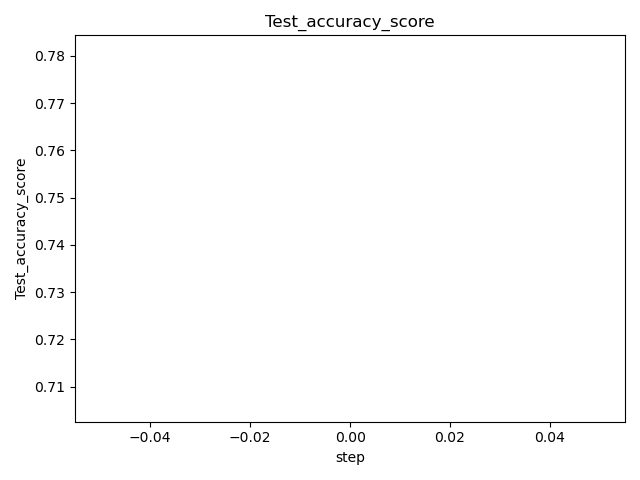

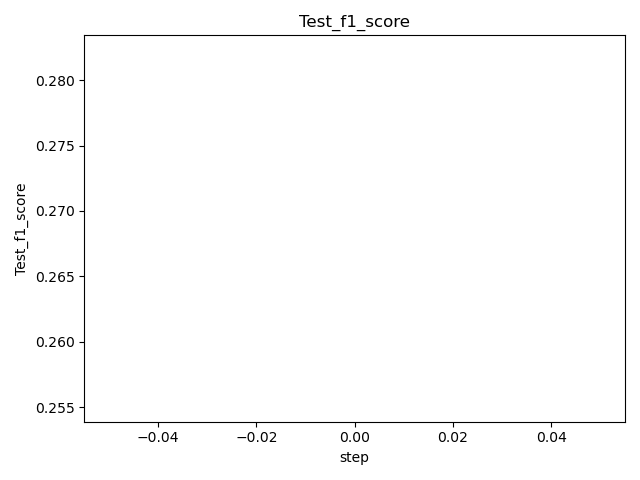

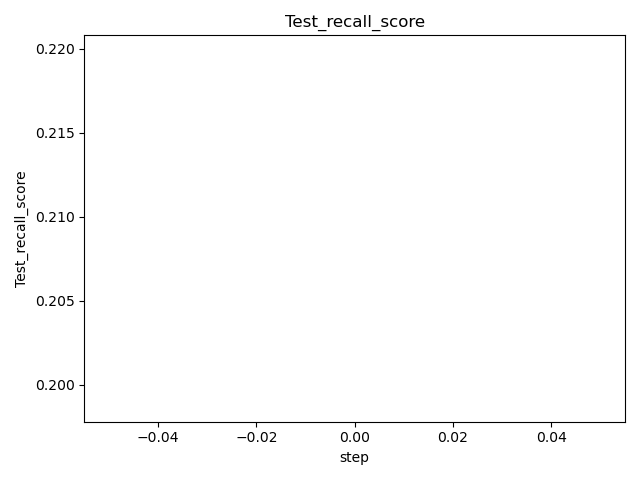

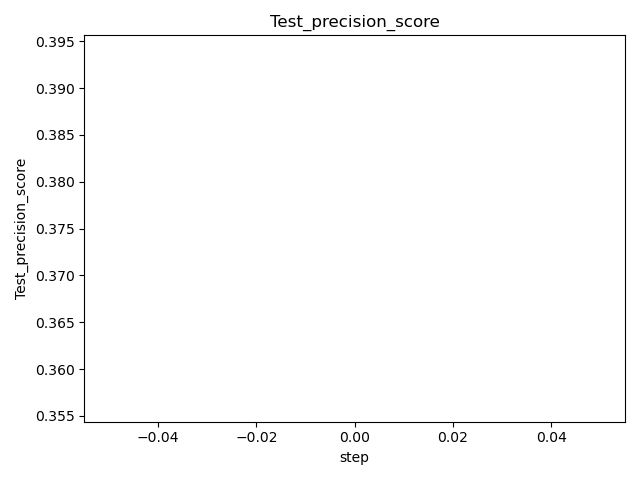

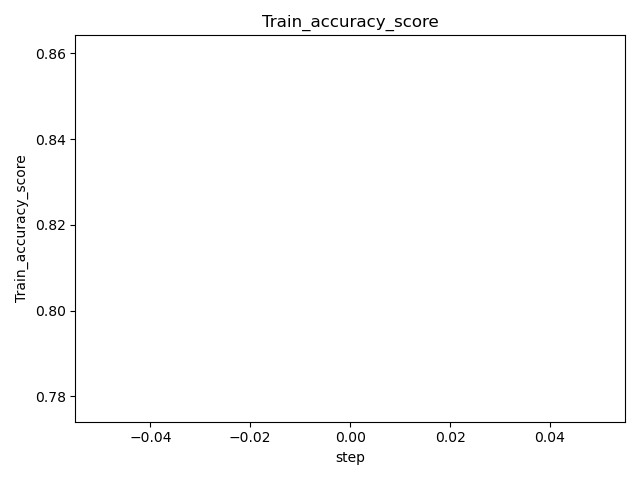

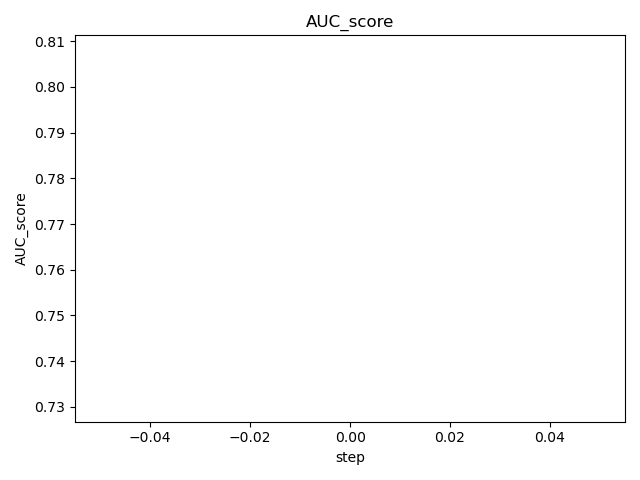



	.DS_Store, demo-01-ChurnPrediction.ipynb, dvc_plots/index.html, .ipynb_checkpoints/demo-01-ChurnPrediction-checkpoint.ipynb, data/.DS_Store, data/.gitignore
/Users/loonycorn/anaconda3/lib/python3.10/site-packages/dvc_render/vega.py:98: UserWarning: `generate_markdown` can only be used with `LinearTemplate`
  warn("`generate_markdown` can only be used with `LinearTemplate`")


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from dvclive import Live
lr_model = LogisticRegression()
    
pipe_lr = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', lr_model)])
model_params = lr_model.get_params()
print(model_params)
pipe_lr.fit(X_train, y_train)
 
predictions = pipe_lr.predict(X_test)
predictions_predict_prob = pipe_lr.predict_proba(X_test)
    
train_accuracy_score = pipe_lr.score(X_train, y_train)
test_accuracy_score = accuracy_score(y_test, predictions)
test_precision_score = precision_score(y_test, predictions)
test_recall_score = recall_score(y_test, predictions)
test_f1_score = f1_score(y_test, predictions)
auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    
metrics = {
        'Train_accuracy_score': train_accuracy_score, 
        'Test_accuracy_score': test_accuracy_score,
        'Test_precision_score': test_precision_score,
        'Test_recall_score': test_recall_score,
        'Test_f1_score': test_f1_score,
        'AUC_score': auc_score }
    
with Live(save_dvc_exp = True, report = 'notebook') as live:
    live.log_params(model_params)
        
    live.log_metric('Train_accuracy_score',train_accuracy_score)
    live.log_metric('Test_accuracy_score',test_accuracy_score)
    live.log_metric('Test_precision_score', test_precision_score)
    live.log_metric('Test_recall_score', test_recall_score)
    live.log_metric('Test_f1_score', test_f1_score)
    live.log_metric('AUC_score', auc_score)
    
    live.log_sklearn_plot('confusion_matrix', y_test, predictions, name = 'cm.json')
    

RandomForest Model is trained and parameters and metrics are logged.It can easily seen that this experiment's performance is quite better than Logistic Regression Experiment.


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


# DVC Report

params.yaml

| bootstrap   |   ccp_alpha | class_weight   | criterion   | max_depth   | max_features   | max_leaf_nodes   | max_samples   |   min_impurity_decrease |   min_samples_leaf |   min_samples_split |   min_weight_fraction_leaf |   n_estimators | n_jobs   | oob_score   | random_state   |   verbose | warm_start   |
|-------------|-------------|----------------|-------------|-------------|----------------|------------------|---------------|-------------------------|--------------------|---------------------|----------------------------|----------------|----------|-------------|----------------|-----------|--------------|
| True        |           0 |                | gini        |             | sqrt           |                  |               |                       0 |                  1 |                   2 |                          0 |            100 |          | False       |                |         0 | False        |

metrics.json

|   Train_accuracy_score |   Test_accuracy_score |   Test_precision_score |   Test_recall_score |   Test_f1_score |   AUC_score |
|------------------------|-----------------------|------------------------|---------------------|-----------------|-------------|
|               0.954128 |              0.848168 |               0.659091 |            0.674419 |        0.666667 |    0.906427 |

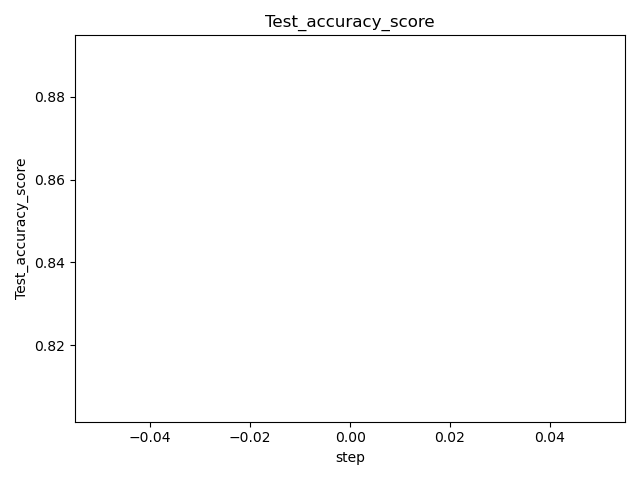

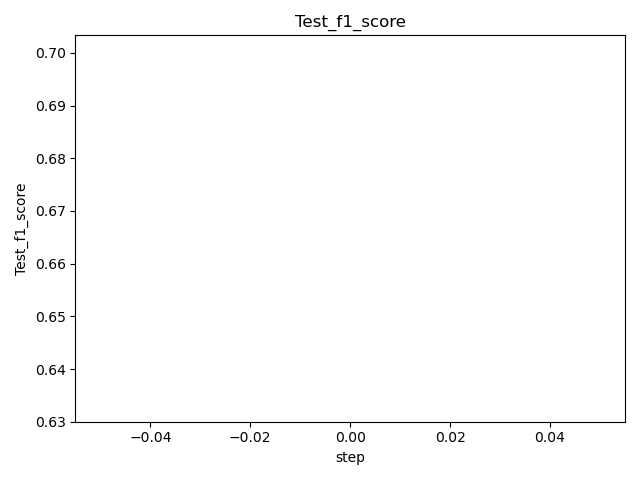

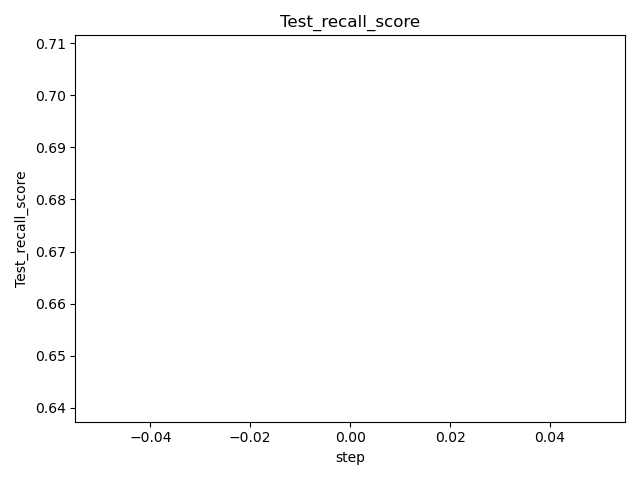

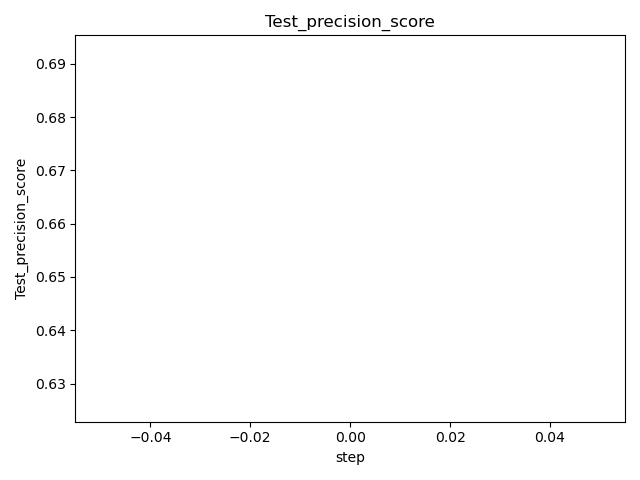

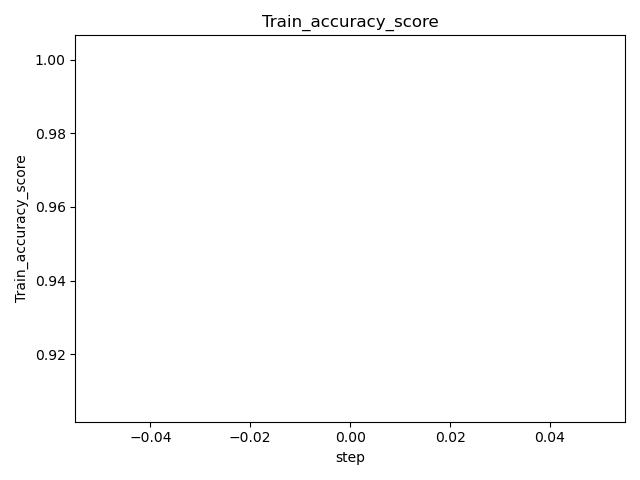

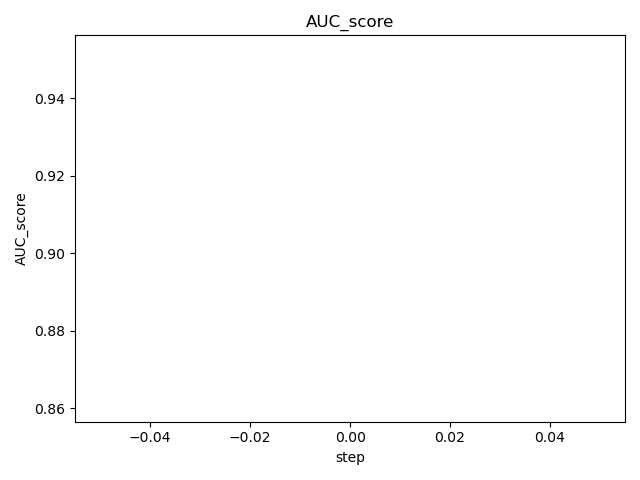



	.DS_Store, demo-01-ChurnPrediction.ipynb, dvc_plots/index.html, .ipynb_checkpoints/demo-01-ChurnPrediction-checkpoint.ipynb, data/.DS_Store, data/.gitignore
/Users/loonycorn/anaconda3/lib/python3.10/site-packages/dvc_render/vega.py:98: UserWarning: `generate_markdown` can only be used with `LinearTemplate`
  warn("`generate_markdown` can only be used with `LinearTemplate`")


In [13]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
    
pipe_rf = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', rf_model)])
model_params = rf_model.get_params()
print(model_params)
pipe_rf.fit(X_train, y_train)

predictions = pipe_rf.predict(X_test)
predictions_predict_prob = pipe_rf.predict_proba(X_test)
    
train_accuracy_score = pipe_rf.score(X_train, y_train)
test_accuracy_score = accuracy_score(y_test, predictions)
test_precision_score = precision_score(y_test, predictions)
test_recall_score = recall_score(y_test, predictions)
test_f1_score = f1_score(y_test, predictions)
auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    
metrics = {
        'Train_accuracy_score': train_accuracy_score, 
        'Test_accuracy_score': test_accuracy_score,
        'Test_precision_score': test_precision_score,
        'Test_recall_score': test_recall_score,
        'Test_f1_score': test_f1_score,
        'AUC_score': auc_score }
   
with Live(save_dvc_exp = True, report = 'notebook') as live:
    live.log_params(model_params)
        
    live.log_metric('Train_accuracy_score',train_accuracy_score)
    live.log_metric('Test_accuracy_score',test_accuracy_score)
    live.log_metric('Test_precision_score', test_precision_score)
    live.log_metric('Test_recall_score', test_recall_score)
    live.log_metric('Test_f1_score', test_f1_score)
    live.log_metric('AUC_score', auc_score)
    live.log_sklearn_plot('confusion_matrix', y_test, predictions, name = 'cm.json')
    

In [19]:
import mlflow.shap
with mlflow.start_run(run_name = 'LR_model_with_model_explanation') as run1:
 
    lr_model = LogisticRegression()
    
    pipe_lr = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', lr_model)])
    model_params = lr_model.get_params()
    print(model_params)
    pipe_lr.fit(X_train, y_train)
 
    predictions =  pipe_lr.predict(X_test)
    predictions_predict_prob =   pipe_lr.predict_proba(X_test)
    
    train_accuracy_score =   pipe_lr.score(X_train, y_train)
    test_accuracy_score = accuracy_score(y_test, predictions)
    test_precision_score = precision_score(y_test, predictions)
    test_recall_score = recall_score(y_test, predictions)
    test_f1_score = f1_score(y_test, predictions)
    auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    
    metrics = {
        'Train_accuracy_score': train_accuracy_score, 
        'Test_accuracy_score': test_accuracy_score,
        'Test_precision_score': test_precision_score,
        'Test_recall_score': test_recall_score,
        'Test_f1_score': test_f1_score,
        'AUC_score': auc_score }
    mlflow.log_params(model_params)
    
    mlflow.log_metrics(metrics)
    
    signature = infer_signature(X_train,   pipe_lr.predict(X_train))
    
    observations =  pipe_lr.named_steps['preprocessor'].transform(X_train)
    observations_asframe =  pd.DataFrame(observations , columns = preprocessor.get_feature_names_out())
    print(observations_asframe)
    mlflow.shap.log_explanation( pipe_lr.named_steps['classifier'].predict, observations_asframe)

    mlflow.sklearn.log_model(  pipe_lr, 'preprocessing_pipeline_with_logistic_regression_model', signature = signature)
    
    mlflow.set_tag('Classifier', 'LR-default parameters')

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
     cat__FrequentFlyer_No Record  cat__FrequentFlyer_Yes  \
0                             0.0                     0.0   
1                             0.0                     0.0   
2                             0.0                     0.0   
3                             0.0                     0.0   
4                             0.0                     0.0   
..                            ...                     ...   
758                           0.0                     1.0   
759                           0.0                     0.0   
760                           0.0                     1.0   
761                           0.0                     0.0   
762                           0.0                   

/Users/loonycorn/anaconda3/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


  0%|          | 0/763 [00:00<?, ?it/s]

Now we are enabling autologging.Note that auc_score is not autologged.So we need to log it using 'log_metric', everything else is autologged

In [21]:
from sklearn.linear_model import LogisticRegression

from mlflow.models.signature import infer_signature

mlflow.autolog()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
with mlflow.start_run(run_name = 'LR_model_with_params_and_metrics_autologged') as run2:
 
    lr_model = LogisticRegression()
    
    pipe_lr = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', lr_model)])
    pipe_lr.fit(X_train, y_train)
 
    predictions =  pipe_lr.predict(X_test)
    predictions_predict_prob =  pipe_lr.predict_proba(X_test)
    
    test_accuracy_score = accuracy_score(y_test, predictions)
    test_precision_score = precision_score(y_test, predictions)
    test_recall_score = recall_score(y_test, predictions)
    test_f1_score = f1_score(y_test, predictions)
    auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    mlflow.log_metric('AUC_score', auc_score)
      
    signature = infer_signature(X_train,  pipe_lr.predict(X_train))
 
    mlflow.set_tag('Classifier', 'LR-default parameters')

2023/06/04 20:02:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/06/04 20:03:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/06/04 20:03:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2023/06/04 20:03:00 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.
2023/06/04 20:03:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.
2023/06/04 20:03:00 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('cat',
                                 Pipeline(steps=[('

In [22]:
mlflow.autolog()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
with mlflow.start_run(run_name = 'RF_model_with_params_and_metrics_autologged') as run3:
 
    rf_model = RandomForestClassifier()
    
    pipe_rf = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', rf_model )])
    pipe_rf.fit(X_train, y_train)
 
    predictions =  pipe_rf.predict(X_test)
    predictions_predict_prob = pipe_rf.predict_proba(X_test)
    test_accuracy_score = accuracy_score(y_test, predictions)
    test_precision_score = precision_score(y_test, predictions)
    test_recall_score = recall_score(y_test, predictions)
    test_f1_score = f1_score(y_test, predictions)
    auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    mlflow.log_metric('AUC_score', auc_score)
      
    signature = infer_signature(X_train, pipe_rf.predict(X_train))
 
    mlflow.set_tag('Classifier', 'RF-default parameters')

2023/06/04 20:03:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/06/04 20:03:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/06/04 20:03:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2023/06/04 20:03:09 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.
2023/06/04 20:03:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.
2023/06/04 20:03:09 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('cat',
                                 Pipeline(steps=[('

In [23]:
from sklearn.svm import SVC

mlflow.autolog()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
with mlflow.start_run(run_name = 'SVC_model_with_params_and_metrics_autologged') as run4:
 
    svc_model = SVC()
    
    pipe_svc = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', svc_model )])
    pipe_svc.fit(X_train, y_train)
 
    predictions =  pipe_svc.predict(X_test)
    test_accuracy_score = accuracy_score(y_test, predictions)
    test_precision_score = precision_score(y_test, predictions)
    test_recall_score = recall_score(y_test, predictions)
    test_f1_score = f1_score(y_test, predictions)
    signature = infer_signature(X_train, pipe_svc.predict(X_train))
 
    mlflow.set_tag('Classifier', 'SVC-default parameters')

2023/06/04 20:03:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/06/04 20:03:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/06/04 20:03:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2023/06/04 20:03:16 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.
2023/06/04 20:03:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.
2023/06/04 20:03:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/loonycorn/anaconda3/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). I

In [24]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [25]:
mlflow.autolog()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
with mlflow.start_run(run_name = 'GB_model_with_params_and_metrics_autologged') as run5:
 
    gb_model = GradientBoostingClassifier()
    
    pipe_gb = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', gb_model )])
    pipe_gb.fit(X_train, y_train)
    
    predictions =  pipe_gb.predict(X_test)
    predictions_predict_prob = pipe_gb.predict_proba(X_test)
    
    test_accuracy_score = accuracy_score(y_test, predictions)
    test_precision_score = precision_score(y_test, predictions)
    test_recall_score = recall_score(y_test, predictions)
    test_f1_score = f1_score(y_test, predictions)
    
    auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    mlflow.log_metric('AUC_score', auc_score)
    
    signature = infer_signature(X_train, pipe_gb.predict(X_train))
 
    mlflow.set_tag('Classifier', 'GB-default parameters')

2023/06/04 20:03:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/06/04 20:03:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/06/04 20:03:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2023/06/04 20:03:21 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.
2023/06/04 20:03:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.
2023/06/04 20:03:22 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('cat',
                                 Pipeline(steps=[('

In [26]:
from xgboost.sklearn import XGBClassifier

mlflow.autolog()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
with mlflow.start_run(run_name = 'XGB_model_with_params_and_metrics_autologged') as run6:
 
    xgb_model = XGBClassifier()
    
    pipe_xgb = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', xgb_model )])
    pipe_xgb.fit(X_train, y_train)
 
    predictions =  pipe_xgb.predict(X_test)
    predictions_predict_prob = pipe_xgb.predict_proba(X_test)
    
    test_accuracy_score = accuracy_score(y_test, predictions)
    test_precision_score = precision_score(y_test, predictions)
    test_recall_score = recall_score(y_test, predictions)
    test_f1_score = f1_score(y_test, predictions)
    
    auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    mlflow.log_metric('AUC_score', auc_score)
    signature = infer_signature(X_train, pipe_xgb.predict(X_train))
 
    mlflow.set_tag('Classifier', 'XGBOOST-default parameters')

2023/06/04 20:03:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/06/04 20:03:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/06/04 20:03:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/06/04 20:03:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/06/04 20:03:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2023/06/04 20:03:28 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.
2023/06/04 20:03:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.
2023/06/04 20:03:28 WARNING mlflow.utils: Truncated the value of 

Click on the + button next to the runs and add metrics for AUC_score, accuracy_score_X_test, and f1_score_X_test
Note that the GBM model is the most accurate

In [33]:
client = mlflow.tracking.MlflowClient()
experiments_list = client.search_experiments()
 
experiments_list

[<Experiment: artifact_location='file:///Users/loonycorn/Downloads/LOONY_MLFLOW_EXP/mlruns/970011492407650420', creation_time=1685856980640, experiment_id='970011492407650420', last_update_time=1685856980640, lifecycle_stage='active', name='Customer_churn_prediction', tags={}>,
 <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1684829927020, experiment_id='0', last_update_time=1684829927020, lifecycle_stage='active', name='Default', tags={}>]

Listing all experiments

In [34]:
experiment = mlflow.get_experiment_by_name(experiments_list[0].name)
 
experiment

<Experiment: artifact_location='file:///Users/loonycorn/Downloads/LOONY_MLFLOW_EXP/mlruns/970011492407650420', creation_time=1685856980640, experiment_id='970011492407650420', last_update_time=1685856980640, lifecycle_stage='active', name='Customer_churn_prediction', tags={}>

In [35]:
df_run_metrics

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Test_accuracy_score,metrics.Test_precision_score,metrics.AUC_score,metrics.Test_f1_score,...,params.min_impurity_decrease,params.splitter,params.max_depth,params.criterion,params.max_features,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.log-model.history
0,80234dbc2173416e8199e976a504a9ea,569571965878103909,FAILED,file:///Users/loonycorn/Downloads/LOONY_MLFLOW...,2023-06-04 14:23:59.940000+00:00,2023-06-04 14:26:39.587000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,LOCAL,loonycorn,kindly-kite-216,/Users/loonycorn/anaconda3/lib/python3.10/site...,None
1,c8ff5d0c83c34c30a8c6e19364e6b7f2,569571965878103909,FAILED,file:///Users/loonycorn/Downloads/LOONY_MLFLOW...,2023-06-04 14:21:37.064000+00:00,2023-06-04 14:23:52.645000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,LOCAL,loonycorn,redolent-rat-318,/Users/loonycorn/anaconda3/lib/python3.10/site...,None
2,b0fbf8173afc4752ba96b0076d9bf727,569571965878103909,FAILED,file:///Users/loonycorn/Downloads/LOONY_MLFLOW...,2023-06-04 14:19:11.286000+00:00,2023-06-04 14:20:32.715000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,LOCAL,loonycorn,magnificent-deer-457,/Users/loonycorn/anaconda3/lib/python3.10/site...,None
3,d99ebf756013449d9975760e78478a3b,569571965878103909,FAILED,file:///Users/loonycorn/Downloads/LOONY_MLFLOW...,2023-06-04 14:18:02.684000+00:00,2023-06-04 14:18:58.980000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,LOCAL,loonycorn,silent-mink-509,/Users/loonycorn/anaconda3/lib/python3.10/site...,None
4,dde8427370de48068048dd83e4158d90,569571965878103909,FINISHED,file:///Users/loonycorn/Downloads/LOONY_MLFLOW...,2023-06-04 12:26:07.186000+00:00,2023-06-04 12:27:13.601000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,LOCAL,loonycorn,ambitious-cow-9,/Users/loonycorn/anaconda3/lib/python3.10/site...,None
5,934e87a2d7d04966819d17078c46fdaf,569571965878103909,FINISHED,file:///Users/loonycorn/Downloads/LOONY_MLFLOW...,2023-06-04 12:11:40.587000+00:00,2023-06-04 12:12:26.874000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,LOCAL,loonycorn,smiling-seal-866,/Users/loonycorn/anaconda3/lib/python3.10/site...,None
6,f6cdbfd6040d49c78b07d96236c4f8c5,569571965878103909,FAILED,file:///Users/loonycorn/Downloads/LOONY_MLFLOW...,2023-06-04 12:09:39.620000+00:00,2023-06-04 12:10:47.539000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,LOCAL,loonycorn,dapper-gnu-969,/Users/loonycorn/anaconda3/lib/python3.10/site...,None
7,b3114a7ac1ba4275b1a70b5185a7e27b,569571965878103909,FAILED,file:///Users/loonycorn/Downloads/LOONY_MLFLOW...,2023-06-04 12:08:24.541000+00:00,2023-06-04 12:09:01.173000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,LOCAL,loonycorn,kindly-auk-853,/Users/loonycorn/anaconda3/lib/python3.10/site...,None
8,87e4ab4495a04099bedd67f5e3bc8215,569571965878103909,FAILED,file:///Users/loonycorn/Downloads/LOONY_MLFLOW...,2023-06-04 12:05:22.496000+00:00,2023-06-04 12:05:59.515000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,LOCAL,loonycorn,carefree-turtle-175,/Users/loonycorn/anaconda3/lib/python3.10/site...,None
9,f4396a6b0af2427a9f41b5d7b3562b14,569571965878103909,FAILED,file:///Users/loonycorn/Downloads/LOONY_MLFLOW...,2023-06-04 12:04:00.125000+00:00,2023-06-04 12:04:55.543000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,LOCAL,loonycorn,marvelous-kit-5,/Users/loonycorn/anaconda3/lib/python3.10/site...,None


We are first choosing Accuracy score on test set as criteria for choosing best model

In [36]:
df_run_metrics = mlflow.search_runs([experiment.experiment_id], order_by = ['metrics.accuracy_score_X_test DESC'])
 
df_run_metrics[['run_id', 'tags.Classifier', 'metrics.accuracy_score_X_test']]

,run_id,tags.Classifier,metrics.accuracy_score_X_test
0,c364a984b3954e0aae5a38d14b059bdc,GB-default parameters,0.858639
1,ebb2589485894e54aaee93178a803feb,GB-default parameters,0.858639
2,548d520620fc4e168c0cc98339cfbcb0,RF-default parameters,0.853403
3,30aadacea2d74808be1d9f0e19c1a7d6,XGBOOST-default parameters,0.848168
4,d3b0fc3799f447dda5c3f507e41705f4,XGBOOST-default parameters,0.848168
5,222d2b38be864513946234be26fbc503,XGBOOST-default parameters,0.848168
6,91f41a1002f247c1bba7f92cf6efc3fc,RF-default parameters,0.842932
7,dbffa76de2e943e29fd8fe161b79a90a,SVC-default parameters,0.785340
8,03ae6df65e0843c0844b5efec6d34a9a,SVC-default parameters,0.785340
9,651084f3931f4008a75c16a7a99f7eb8,LR-default parameters,0.743455


Best run id is obtained

In [37]:
best_run_id = df_run_metrics.loc[0, 'run_id']
 
best_run_id

'c364a984b3954e0aae5a38d14b059bdc'

Classifier name and Run names are extracted.

In [38]:
print('Classifier_name :', df_run_metrics.loc[0, 'tags.Classifier'])
 
print('Run_name :', df_run_metrics.loc[0, 'tags.mlflow.runName'])

Classifier_name : GB-default parameters
Run_name : GB_model_with_params_and_metrics_autologged


Model uri is obtained

In [39]:
model_uri = 'runs:/' + best_run_id + '/model'
 
model_uri

'runs:/c364a984b3954e0aae5a38d14b059bdc/model'

Loading our best model using mlflow.sklearn

In [40]:
import mlflow.sklearn
 
best_model = mlflow.sklearn.load_model(model_uri = model_uri)
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['FrequentFlyer',
                                                   'AccountSyncedToSocialMedia',
                                                   'BookedHotelOrNot'])])),
                ('classifier', GradientBoostingClassifier())])

Loaded model is used for predictions

In [41]:
predictions_loaded = best_model.predict(X_test)
 
predictions_loaded

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0])

In [73]:
predictions_original = pipe_xgb.predict(X_test)
 
predictions_original

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0])

Original model i.e lr is used for predictions

In [43]:
predictions_original = pipe_gb.predict(X_test)
 
predictions_original

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0])

In [44]:
assert(np.array_equal(predictions_loaded, predictions_original))

We are doing Model Registration using best run id based on test set accuracy metric.

In [45]:
model_name = 'churn_prediction_model'
 
model_version = mlflow.register_model(f'runs:/{best_run_id}/model', model_name)

Registered model 'churn_prediction_model' already exists. Creating a new version of this model...
2023/06/04 20:09:11 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: churn_prediction_model, version 2
Created version '2' of model 'churn_prediction_model'.


Open up Models on the left navigation pane in a new tab
Show that the LR model is now registered there - click through to the loan_approval_lr_model
Click on "Use model for inference" on the top-right hand corner
Click on each of the 3 tabs and show
"Batch inference", "Real-time", "Streaming (Delta Live Tables)"
Come back to Batch Inference that is what we will do first
Run batch inference on the model

In a new tab
Open up left navigation pane -> Data -> Add Data
Select processed_x_test from DBFS
Create a table using the UI
Name the table x_test_data
Check "First row is header" and "Infer Schema"
Create the Delta Table
In the models tab choose this table for batch inference
Specify the values in the input
Run the noteobook that has been created
Show the inferred data

Back to the Models page and click on the loan_approval_lr_model
Click on the version link and show the model page
Change the stage of the model to move it to Staging
You will find the model transition request in "Pending requests"
Go ahead and Approve the request (Uncheck the checkbox which says to Archive the model)
Your model should now be in Staging
Click on loan_approval_lr_model and show that Version 1 is in staging
Keep this tab open.After executing below cell, Go back to the loan_approval_lr_model and show that Version 1 is now in Production

In [46]:
from mlflow.tracking import MlflowClient
 
client = MlflowClient()
 
client.transition_model_version_stage(
  name = model_name,
  version = model_version.version,
  stage = 'Production',
)


<ModelVersion: aliases=[], creation_timestamp=1685889551303, current_stage='Production', description=None, last_updated_timestamp=1685889558961, name='churn_prediction_model', run_id='c364a984b3954e0aae5a38d14b059bdc', run_link=None, source='file:///Users/loonycorn/Downloads/LOONY_MLFLOW_EXP/mlruns/970011492407650420/c364a984b3954e0aae5a38d14b059bdc/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>

Now the model can be loaded from any stage by using 'pyfunc.load_model' and accuracy score on test set can be obtained which is same as seen in the metrics obtained for the particular run.

In [47]:
model_name = 'churn_prediction_model'
stage = 'Production'
 
loaded_model = mlflow.pyfunc.load_model(
    model_uri = f'models:/{model_name}/{stage}'
)
 
print(f'Accuracy_Test_set: {accuracy_score(y_test, loaded_model.predict(X_test))}')

2023/06/04 20:09:22 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


Accuracy_Test_set: 0.8586387434554974


In [48]:
df_run_metrics.loc[0, 'metrics.accuracy_score_X_test']

0.8586387434554974

If we consider recall score as the metrics for choosing model, Then we can move the best run in terms of recall score to Production

In [49]:
best_run_recall_metrics = mlflow.search_runs([experiment.experiment_id], order_by = ['metrics.recall_score_X_test DESC'])
 
best_run_recall_metrics[['run_id', 'tags.Classifier', 'metrics.recall_score_X_test']]

,run_id,tags.Classifier,metrics.recall_score_X_test
0,30aadacea2d74808be1d9f0e19c1a7d6,XGBOOST-default parameters,0.720930
1,d3b0fc3799f447dda5c3f507e41705f4,XGBOOST-default parameters,0.720930
2,222d2b38be864513946234be26fbc503,XGBOOST-default parameters,0.720930
3,548d520620fc4e168c0cc98339cfbcb0,RF-default parameters,0.720930
4,91f41a1002f247c1bba7f92cf6efc3fc,RF-default parameters,0.674419
5,c364a984b3954e0aae5a38d14b059bdc,GB-default parameters,0.604651
6,ebb2589485894e54aaee93178a803feb,GB-default parameters,0.604651
7,dbffa76de2e943e29fd8fe161b79a90a,SVC-default parameters,0.372093
8,03ae6df65e0843c0844b5efec6d34a9a,SVC-default parameters,0.372093
9,651084f3931f4008a75c16a7a99f7eb8,LR-default parameters,0.209302


In [50]:
print('Classifier_name :', best_run_recall_metrics.loc[0, 'tags.Classifier'])
 
print('Run_name :', best_run_recall_metrics.loc[0, 'tags.mlflow.runName'])
 
print('Best recall score :', best_run_recall_metrics.loc[0, 'metrics.recall_score_X_test'])

Classifier_name : XGBOOST-default parameters
Run_name : XGB_model_with_params_and_metrics_autologged
Best recall score : 0.7209302325581395


In [51]:
best_recall_model_name = 'churn_prediction_new_model'
 
best_recall_model = mlflow.register_model(f"runs:/{best_run_recall_metrics.loc[0, 'run_id']}/model", best_recall_model_name)

Registered model 'churn_prediction_new_model' already exists. Creating a new version of this model...
2023/06/04 20:09:53 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: churn_prediction_new_model, version 2
Created version '2' of model 'churn_prediction_new_model'.


Model's version specific description can be updated by using 'update_model_version'

In [ ]:
client.update_model_version(
    name = 'churn_prediction_new_model',
    version = 1,
    description = 'This model version is a XGBOOST model which had the best recall score'
)
 

In [ ]:
client.update_model_version(
    name = 'churn_prediction_model',
    version = 1,
    description = 'This model version is a GBM random which had the best accuracy score '
)

Archiving old model

In [52]:
client.transition_model_version_stage(
  name = model_name,
  version = model_version.version,
  stage = 'Archived'
)

<ModelVersion: aliases=[], creation_timestamp=1685889551303, current_stage='Archived', description=None, last_updated_timestamp=1685889596643, name='churn_prediction_model', run_id='c364a984b3954e0aae5a38d14b059bdc', run_link=None, source='file:///Users/loonycorn/Downloads/LOONY_MLFLOW_EXP/mlruns/970011492407650420/c364a984b3954e0aae5a38d14b059bdc/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>

New model moved to Production

In [53]:
client.transition_model_version_stage(
  name = best_recall_model_name,
  version = best_recall_model.version,
  stage = 'Production'
)

<ModelVersion: aliases=[], creation_timestamp=1685889593751, current_stage='Production', description=None, last_updated_timestamp=1685889600022, name='churn_prediction_new_model', run_id='30aadacea2d74808be1d9f0e19c1a7d6', run_link=None, source='file:///Users/loonycorn/Downloads/LOONY_MLFLOW_EXP/mlruns/970011492407650420/30aadacea2d74808be1d9f0e19c1a7d6/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>

For serving the logged model locally..Below commands are run in Terminal

In [ ]:
mlflow models serve -m runs:/218730dbcd6441d5bed4e65fa2df42ea/model --env-manager local --host 127.0.0.1:1234

In [ ]:
curl -X POST -H "Content-Type:application/json" --data '{"dataframe_split": {"columns":["Age","FrequentFlyer","AnnualIncomeClass","ServicesOpted","AccountSyncedToSocialMedia","BookedHotelOrNot"],"data":[[35,"Yes",2,1,"No","No"]]}}' http://127.0.0.1:1234/invocations

For serving the logged model in Azure ML studio, we need to install some packages related to azure

In [ ]:
pip install azureml-core

In [ ]:
pip install azure-ai-ml azure-identity

In [ ]:
pip install azureml-mlflow

In [56]:
from azureml.core import Workspace
ws = Workspace.create(name = 'loony-mlflow-ws',
                      subscription_id = '0fec7b07-1efc-48ea-b142-6ed379f356be',
                      resource_group = 'loony-mlflow-rg',
                      create_resource_group = False,
                      location = 'eastus'
                     )

Deploying AppInsights with name loonymlfinsightsbbb9fa50.
Deployed AppInsights with name loonymlfinsightsbbb9fa50. Took 11.51 seconds.
Deploying KeyVault with name loonymlfkeyvault31bc6e46.
Deploying StorageAccount with name loonymlfstoragea42728946.
Deployed KeyVault with name loonymlfkeyvault31bc6e46. Took 29.41 seconds.
Deployed StorageAccount with name loonymlfstoragea42728946. Took 29.61 seconds.
Deploying Workspace with name loony-mlflow-ws.
Deployed Workspace with name loony-mlflow-ws. Took 44.63 seconds.


In [57]:
from azureml.core.model import Model

model = Model.register(workspace = ws, model_path = '/Users/loonycorn/Downloads/LOONY_MLFLOW_EXP/mlruns/970011492407650420/30aadacea2d74808be1d9f0e19c1a7d6/artifacts/model', model_name = 'churn-prediction-model')

Registering model churn-prediction-model


In [58]:
import json
from mlflow.deployments import get_deploy_client

# Create the deployment configuration.
# If no deployment configuration is provided, then the deployment happens on ACI.
deploy_config = {"computeType": "aci"}

# Write the deployment configuration into a file.
deployment_config_path = "deployment_config.json"
with open(deployment_config_path, "w") as outfile:
    outfile.write(json.dumps(deploy_config))

In [63]:
# Set the tracking uri in the deployment client.
client = get_deploy_client("azureml://eastus.api.azureml.ms/mlflow/v1.0/subscriptions/0fec7b07-1efc-48ea-b142-6ed379f356be/resourceGroups/loony-mlflow-rg/providers/Microsoft.MachineLearningServices/workspaces/loony-mlflow-ws")

# MLflow requires the deployment configuration to be passed as a dictionary.
config = {"deploy-config-file": deployment_config_path}
model_name = 'churn-prediction-model'
model_version = 1

In [60]:
mlflow.set_tracking_uri('azureml://eastus.api.azureml.ms/mlflow/v1.0/subscriptions/0fec7b07-1efc-48ea-b142-6ed379f356be/resourceGroups/loony-mlflow-rg/providers/Microsoft.MachineLearningServices/workspaces/loony-mlflow-ws')

In [64]:
# define the model path and the name is the service name
# if model is not registered, it gets registered automatically and a name is autogenerated using the "name" parameter below
client.create_deployment(
    model_uri = f"models:/{model_name}/{model_version}",
    config = config,
    name = "churn-pred-model-aci-deployment",
)

Running
2023-06-04 20:23:45+05:30 Creating Container Registry if not exists....................
2023-06-04 20:33:45+05:30 Registering the environment.
2023-06-04 20:33:46+05:30 Building image..............
2023-06-04 20:44:02+05:30 Generating deployment configuration.
2023-06-04 20:44:03+05:30 Submitting deployment to compute.
2023-06-04 20:44:08+05:30 Checking the status of deployment churn-pred-model-aci-deployment.
2023-06-04 20:46:32+05:30 Checking the status of inference endpoint churn-pred-model-aci-deployment.
Succeeded
AciService creation operation finished, operation "Succeeded"


{'name': 'churn-pred-model-aci-deployment',
 'description': None,
 'tags': {},
 'properties': {'hasInferenceSchema': 'True',
  'hasHttps': 'False',
  'authEnabled': 'False'},
 'state': 'Healthy',
 'createdTime': '2023-06-04T14:53:40.874905+00:00',
 'updatedTime': '2023-06-04T14:53:40.874905+00:00',
 'error': None,
 'computeType': 'ACI',
 'workspaceName': 'loony-mlflow-ws',
 'imageId': None,
 'imageDigest': None,
 'imageDetails': None,
 'scoringUri': 'http://8c853db2-9b73-444d-a623-6e022eda870c.eastus.azurecontainer.io/score',
 'createdBy': {'userObjectId': 'bfef73d0-5937-45a8-8eda-c1dc1f2c9a68',
  'userPuId': '100320028973ED65',
  'userIss': 'https://sts.windows.net/89e6e9e4-4e5f-48b1-a30e-88856f345315/',
  'userTenantId': '89e6e9e4-4e5f-48b1-a30e-88856f345315',
  'userName': 'Contact Loonycorn',
  'upn': 'contact@loonycorn.com'},
 'containerResourceRequirements': {'cpu': 0.1, 'memoryInGB': 0.5},
 'location': 'eastus',
 'authEnabled': False,
 'sslEnabled': False,
 'appInsightsEnabled':

End point is consumed for getting prediction

In [76]:
import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.

# Request data goes here
# The example below assumes JSON formatting which may be updated
# depending on the format your endpoint expects.
# More information can be found here:
# https://docs.microsoft.com/azure/machine-learning/how-to-deploy-advanced-entry-script
data =  {
  "input_data": {
    "columns": [
      "Age",
      "FrequentFlyer",
      "AnnualIncomeClass",
      "ServicesOpted",
      "AccountSyncedToSocialMedia",
      "BookedHotelOrNot"
    ],
    "index": [6],
    "data": [[28, 'Yes', 2, 6, 'No', 'Yes']]
  }
}

body = str.encode(json.dumps(data))

url = 'http://8c853db2-9b73-444d-a623-6e022eda870c.eastus.azurecontainer.io/score'


headers = {'Content-Type':'application/json'}

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(error.read().decode("utf8", 'ignore'))

b'[1]'


Deleting the registered model

In [ ]:
client = MlflowClient()

client.delete_registered_model(name = 'churn-prediction-model')